In this notebook, timeseries data of certain stocks will be explored for forecasting. To make forecasting acheivable multiple methods will be tested and compared.

First we need to tranform the timeseries data to be weakly stationary.

Weakly stationary is met when:
- The mean of the process is constant over time
- The variance of the process is constant over time
- The covariance between values of the process at two different times depends only on the time difference and not on time itselft.

In [67]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from statsmodels.tsa.tsatools import detrend
import seaborn as sns


In [69]:
histData = pd.read_csv('../data/tsla_daily.csv')
print(histData.describe())
print()
histData.head()

             Open        High         Low       Close        Volume
count  444.000000  444.000000  444.000000  444.000000  4.440000e+02
mean   241.231607  246.892110  235.067830  240.928679  1.110572e+08
std     58.977818   60.055467   57.361312   58.483914  4.320942e+07
min    103.000000  111.750000  101.809998  108.099998  4.186470e+07
25%    193.797504  197.627499  189.440002  194.285000  7.928550e+07
50%    244.418335  250.791664  239.251663  244.259995  1.016746e+08
75%    282.880821  288.527512  275.507492  282.595009  1.354173e+08
max    396.516663  402.666656  378.679993  399.926666  3.065906e+08



,Date,Open,High,Low,Close,Volume
0,2022-01-03 00:00:00-05:00,382.583344,400.356659,378.679993,399.926666,103931400
1,2022-01-04 00:00:00-05:00,396.516663,402.666656,374.350006,383.196655,100248300
2,2022-01-05 00:00:00-05:00,382.216675,390.113342,360.336670,362.706665,80119800
3,2022-01-06 00:00:00-05:00,359.000000,362.666656,340.166656,354.899994,90336600
4,2022-01-07 00:00:00-05:00,360.123322,360.309998,336.666656,342.320007,84164700


<AxesSubplot: xlabel='Date', ylabel='Close'>

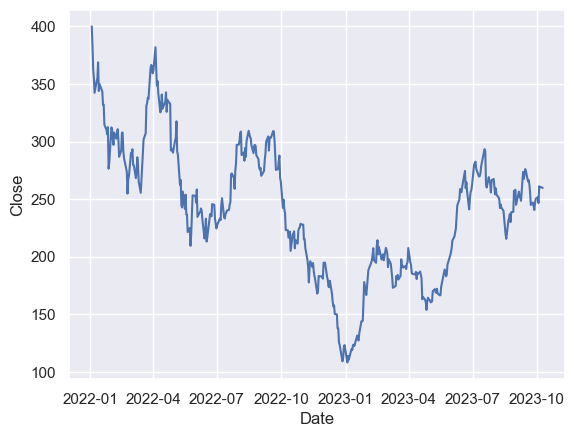

In [72]:
histData['Date'] = pd.to_datetime(histData['Date'], utc=True)

sns.set_theme()
sns.lineplot(data=histData, x = histData['Date'], y = histData['Close'])

#### De-Trending

<AxesSubplot: xlabel='Date', ylabel='Adj_Close'>

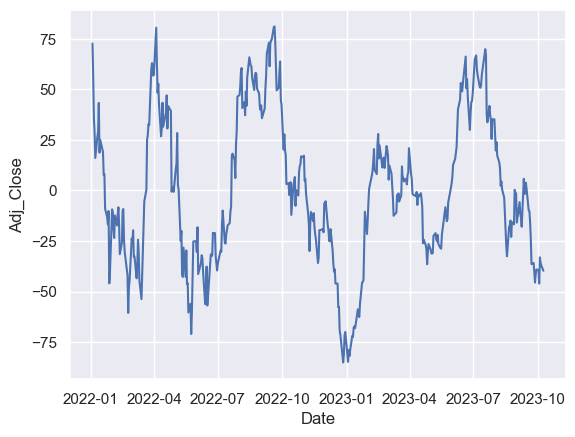

In [74]:

detrend_df = histData.copy()

detrend_df['Adj_Close'] = detrend(detrend_df['Close'], order=3)
detrend_df['Date'] = pd.to_datetime(detrend_df['Date'], utc=True)

sns.lineplot(detrend_df, x = detrend_df['Date'], y = detrend_df['Adj_Close'])


#### First-Order and Higher Order Differencing

In [ ]:
diff_one = detrend_df['Close'].diff()
diff_two = detrend_Df['Clos']

#### Return

#### Log Return